In [12]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import torch
import os
import re

In [31]:
from tensorboard.backend.event_processing import event_accumulator

# logs are in directories: llm_thesis_logs/unlearn.py-{params}/train
# and llm_thesis_logs/unlearn.py-{params}/validation
# collect all of the data

# for unlearn.py-params file in llm_thesislogs:
data = []

for exp_dir in (f.path for f in os.scandir('llm_thesis_logs') if f.is_dir()):
    params = {x.split('=')[0]:x.split('=')[1] for x in re.findall('[a-z]+=[a-zA-Z0-9\.-]+', exp_dir)}
    ea = event_accumulator.EventAccumulator(os.scandir(exp_dir + '/train').__next__().path)
    ea.Reload()
    for tag in ea.Tags()['scalars']:
        params[tag+"-train"] = [x.value for x in ea.Scalars(tag)][-1]
    ea = event_accumulator.EventAccumulator(os.scandir(exp_dir + '/validation').__next__().path)
    ea.Reload()
    for tag in ea.Tags()['scalars']:
        params[tag+"-validation"] = [x.value for x in ea.Scalars(tag)][-1]
    data.append(params)

data[0]

{'bs': '4',
 'b': '1.0',
 'd': 'None',
 'e': '20',
 'ee': '2',
 'km': '1.0',
 'lr': '0.0001',
 'nm': '1.0',
 'rm': '0.5',
 's': '42',
 't': '4',
 'total_loss-train': -0.11478571593761444,
 'npo_loss-train': 0.17709222435951233,
 'retain_loss-train': -0.028634436428546906,
 'kl_retain_loss-train': -0.003870795015245676,
 'retain_regurgitation_score-train': 0.9402500987052917,
 'retain_knowledge_score-train': 0.962435245513916,
 'forget_regurgitation_score-train': 0.22901701927185059,
 'forget_knowledge_score-train': 0.13376623392105103,
 'mia_loss_acc-train': 0.922432005405426,
 'aggregate_score-train': 0.8134518265724182,
 'retain_regurgitation_score-validation': 0.4400239884853363,
 'retain_knowledge_score-validation': 0.38624337315559387,
 'forget_regurgitation_score-validation': 0.4695158898830414,
 'forget_knowledge_score-validation': 0.3988439440727234,
 'aggregate_score-validation': 0.453408420085907}

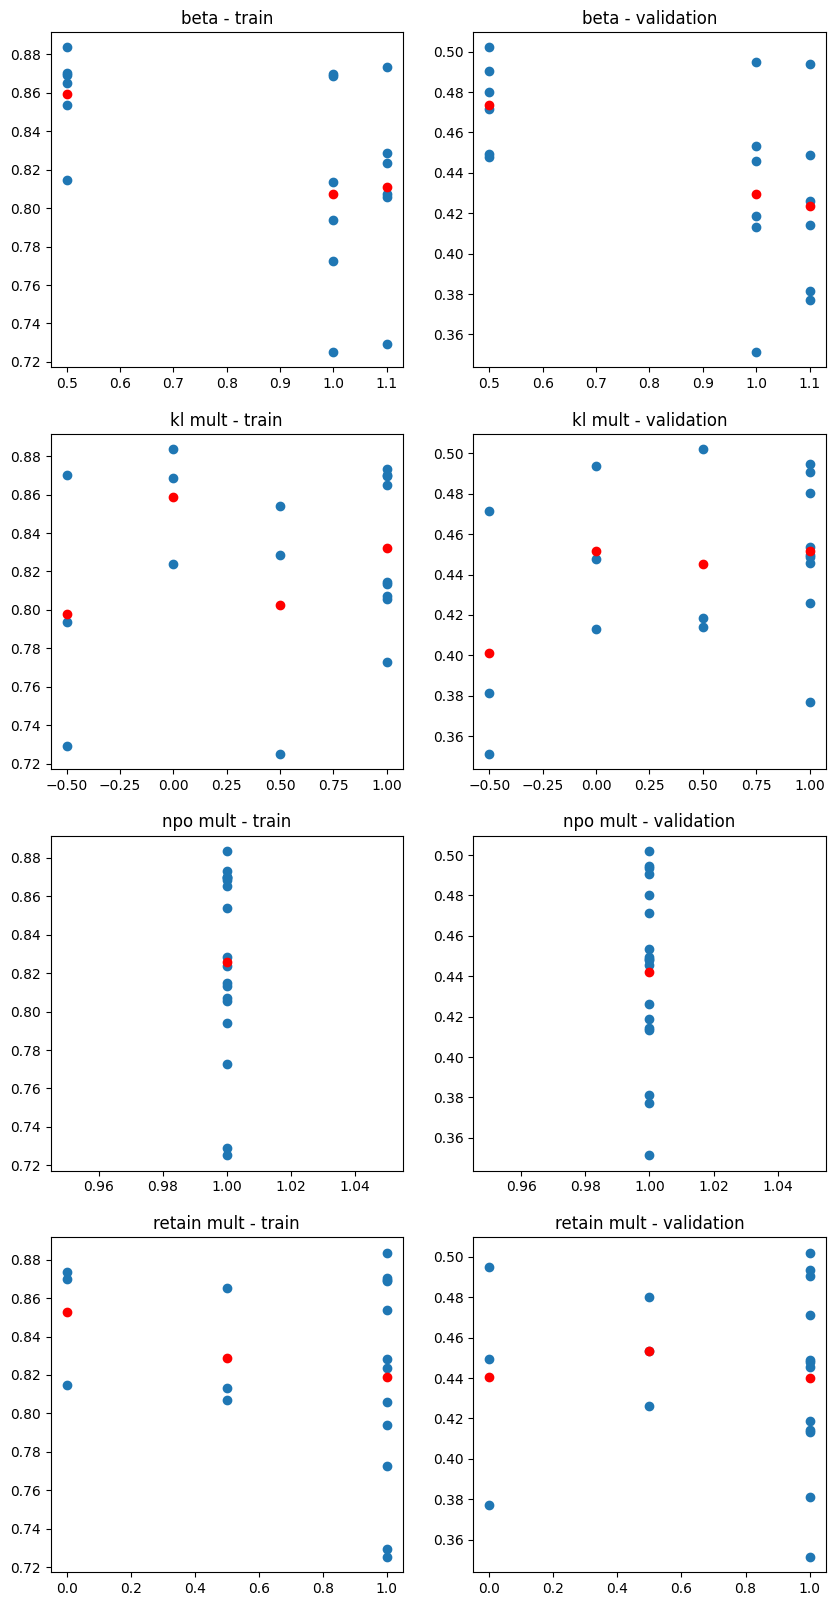

In [53]:
# plot aggregate_score according to parameters: b, km, nm, rm

def data_to_axs(data, param, value, ax: plt.Axes, title):
    ax.scatter([float(x[param]) for x in dataf], [x[value] for x in dataf])
    for p in set([float(x[param]) for x in dataf]):
        mean = numpy.mean([x[value] for x in dataf if float(x[param]) == p])
        ax.scatter([p], [mean], c='r')
    ax.set_title(title)
    
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

dataf = [x for x in data if x['nm'] != '-1.0' and x['km'] != '-1.0']

data_to_axs(dataf, 'b', 'aggregate_score-train', axs[0][0], 'beta - train')
data_to_axs(dataf, 'b', 'aggregate_score-validation', axs[0][1], 'beta - validation')

data_to_axs(dataf, 'km', 'aggregate_score-train', axs[1][0], 'kl mult - train')
data_to_axs(dataf, 'km', 'aggregate_score-validation', axs[1][1], 'kl mult - validation')

data_to_axs(dataf, 'nm', 'aggregate_score-train', axs[2][0], 'npo mult - train')
data_to_axs(dataf, 'nm', 'aggregate_score-validation', axs[2][1], 'npo mult - validation')

data_to_axs(dataf, 'rm', 'aggregate_score-train', axs[3][0], 'retain mult - train')
data_to_axs(dataf, 'rm', 'aggregate_score-validation', axs[3][1], 'retain mult - validation')

plt.show()


In [54]:
# best params on validation score:
best = max(dataf, key=lambda x: x['aggregate_score-validation'])
print(best)

{'bs': '4', 'b': '0.5', 'd': 'None', 'e': '20', 'ee': '2', 'km': '0.5', 'lr': '0.0001', 'nm': '1.0', 'rm': '1.0', 's': '42', 't': '4', 'total_loss-train': -0.206539124250412, 'npo_loss-train': 0.32598385214805603, 'retain_loss-train': -0.026326708495616913, 'kl_retain_loss-train': -0.007945324294269085, 'retain_regurgitation_score-train': 0.9272583723068237, 'retain_knowledge_score-train': 0.9650259017944336, 'forget_regurgitation_score-train': 0.2025509774684906, 'forget_knowledge_score-train': 0.09090909361839294, 'mia_loss_acc-train': 0.9078720211982727, 'aggregate_score-train': 0.8538380861282349, 'retain_regurgitation_score-validation': 0.45765793323516846, 'retain_knowledge_score-validation': 0.43386244773864746, 'forget_regurgitation_score-validation': 0.43696272373199463, 'forget_knowledge_score-validation': 0.45086705684661865, 'aggregate_score-validation': 0.5020149946212769}
